# Modelo TCN para Classificação de Rótulos em Ações da Petrobrás

O problema em análise tem mostrado que o enfoque em padrões mais curtos tem mostrado resultados mais vantajosos. TCN (Temporal Convolutional Network) usa convoluções 1D para modelar dependências temporais sem *look-ahead*. Em séries financeiras com janelas curtas (de 15 passos, como no nosso caso), um TCN raso com kernels pequenos e dilatações moderadas captura padrões locais de curto prazo com eficiência, mantendo baixo risco de overfiting. As conexões residuais e a ausência de pooling intermediário preservam detalhes temporais relevantes, o que costuma resultar em melhor discriminação binária (compra/venda) sob ruído e regime volátil.

Em seu trabalho de 2018, Bai, Kolter e Koltun mostraram como TCN podem performar melhor que outras arquiteturas como LSTM e GRU para modelagem de sequências.
Dai, Wei et. al., 2022 , trataram de um problema de predição de preços de ações e subsequente classificação desses preços e também concluíram que redes convolucionais temporais apresentam uma boa performance, superior a LSTM.
Em um problema de predição de preços de ouro, Fajou e McCarren, 2021, também concluíram que TCN performaram melhor que redes LSTM e redes híbridas CNN-LSTM.

### Importação e tratamento dos dados

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
TRAIN_ID = "1dUdOB1K0eF2AF6YwB1Smk6GF-Ozkicrp"
TEST_ID  = "1dTZTAX6uBnB4qybSpS9rnbwNktHg_iwq"

URL_TRAIN = f"https://drive.google.com/uc?export=download&id={TRAIN_ID}"
URL_TEST  = f"https://drive.google.com/uc?export=download&id={TEST_ID}"

df_train = pd.read_csv(URL_TRAIN)
df_test  = pd.read_csv(URL_TEST)

print("Treino:", df_train.shape, "Teste:", df_test.shape)

Treino: (4808, 20) Teste: (1203, 20)


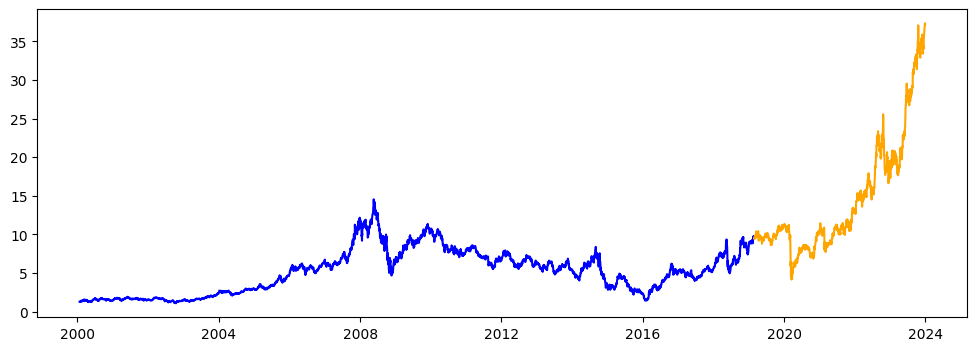

In [ ]:
plt.figure(figsize=(12,4))

df_train["Date"] = pd.to_datetime(df_train["Date"], errors="coerce")
df_test["Date"]  = pd.to_datetime(df_test["Date"], errors="coerce")

plt.plot(df_train["Date"], df_train["Close"], color="blue", label="Treino")
plt.plot(df_test["Date"], df_test["Close"], color="orange", label="Teste")

Pelo gráfico é possível ver que há uma brusca mudança de comportamento nos preços das ações após 2022, período que se encontra dentro do grupo teste. Isso significa que o modelo irá aprender com os dados em azul,  de forma que a captura da tendência apresentada na curva em laranja será mais desafiadora.

In [ ]:
df_train_drop = df_train.drop(columns=['Unnamed: 0', 'Date', 'Close', 'Smoothed_Close'])
df_test_drop = df_test.drop(columns=['Unnamed: 0', 'Date', 'Close', 'Smoothed_Close'])

In [ ]:
df_train_drop["Label"] = df_train_drop["Label"].replace(-1, 0)
print(df_train_drop['Label'].unique())
df_test_drop["Label"] = df_test_drop["Label"].replace(-1, 0)
print(df_test_drop['Label'].unique())

[0 1]
[1 0]


In [ ]:
from sklearn.preprocessing import StandardScaler

X_train = df_train_drop.drop(columns=['Label'])
y_train = df_train_drop["Label"]

X_test = df_test_drop.drop(columns=['Label'])
y_test = df_test_drop["Label"]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


timesteps = X_train_scaled.shape[1]


X_treino = X_train_scaled.reshape(X_train_scaled.shape[0], timesteps, 1)
X_teste  = X_test_scaled.reshape(X_test_scaled.shape[0], timesteps, 1)

# Checagem
print("X_train shape:", X_treino.shape)
print("y_train shape:", y_treino.shape)
print("X_test shape :", X_teste.shape)
print("y_test shape :", y_teste.shape)

X_train shape: (4808, 15, 1)
y_train shape: (4808,)
X_test shape : (1203, 15, 1)
y_test shape : (1203,)


In [ ]:
display(X_treino)

array([[[-1.36678217],
        [-1.35634368],
        [-1.35478927],
        ...,
        [-1.33467108],
        [-1.32920907],
        [-1.30012506]],

       [[-1.37003293],
        [-1.36627341],
        [-1.35584385],
        ...,
        [-1.33634139],
        [-1.33413299],
        [-1.32870209]],

       [[-1.37003293],
        [-1.36952443],
        [-1.36577449],
        ...,
        [-1.33414351],
        [-1.33580334],
        [-1.33362628]],

       ...,

       [[ 1.60390841],
        [ 1.64775666],
        [ 1.56992873],
        ...,
        [ 1.4839996 ],
        [ 1.45543257],
        [ 1.42818583]],

       [[ 1.64954201],
        [ 1.60465509],
        [ 1.64853411],
        ...,
        [ 1.4903416 ],
        [ 1.48460717],
        [ 1.45609388]],

       [[ 1.61531656],
        [ 1.65029234],
        [ 1.60542856],
        ...,
        [ 1.41550499],
        [ 1.49094932],
        [ 1.48527009]]])

# Modelo TCN

Nosso objetivo é focar em padrões de curto prazo, de maneira que podemos trabalhar com um modelo raso e com kernels pequenos.

In [ ]:
!pip install keras-tcn

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tcn import TCN

model = Sequential([
    TCN(input_shape=(timesteps, 1),  # (timesteps, features)
        nb_filters=64,
        kernel_size=3,
        dilations=[1, 2, 4],  # profundidade da rede
        padding='causal',
        dropout_rate=0.2),
    Dense(1, activation='sigmoid')  # binária
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn_5 (TCN)                     │ (None, 64)             │        62,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,209 (243.00 KB)

 Trainable params: 62,209 (243.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('model_best.keras', monitor='val_accuracy', mode= 'auto', save_best_only=True, verbose =1)

In [ ]:
history = model.fit(
    X_treino, y_train,
    validation_data=(X_teste, y_test),
    epochs=40,
    batch_size=64,
    callbacks=[mcp_save],
    shuffle=False           # manter a ordem, já que se trata de série temporal
)


Epoch 1/40
73/76 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6290 - loss: 0.6582
Epoch 1: val_accuracy did not improve from 0.77889
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.6307 - loss: 0.6567 - val_accuracy: 0.5819 - val_loss: 0.9284
Epoch 2/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6231 - loss: 0.6702
Epoch 2: val_accuracy did not improve from 0.77889
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6237 - loss: 0.6698 - val_accuracy: 0.7082 - val_loss: 0.5494
Epoch 3/40
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6258 - loss: 0.6571
Epoch 3: val_accuracy did not improve from 0.77889
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6272 - loss: 0.6557 - val_accuracy: 0.6808 - val_loss: 0.6450
Epoch 4/40
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6219 - loss: 0.6711
Epoch 4: val_accuracy did not improve from 0.77889
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6228 - loss: 0.6702 - val_accuracy: 0.5179 - val_loss:

In [ ]:
from tensorflow.keras.models import load_model

best_model = load_model('model_best.keras')


In [ ]:
predictions_test = best_model.predict(X_teste)
predictions_train = best_model.predict(X_treino)

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
pred_test = np.where(predictions_test > 0.5, 1, 0)
pred_train = np.where(predictions_train > 0.5, 1, 0)

In [ ]:
# Índice da melhor val_accuracy
melhor_epoca = np.argmax(history.history['val_accuracy']) + 1
melhor_val_acc = history.history['val_accuracy'][melhor_epoca - 1]

print(f"Melhor val_accuracy: {melhor_val_acc:.4f} na época {melhor_epoca}")


Melhor val_accuracy: 0.8354 na época 31


o Modelo apresentou uma boa acurácia, sendo capaz de lidar com os diferentes padrões que surgem após o período de 2022.

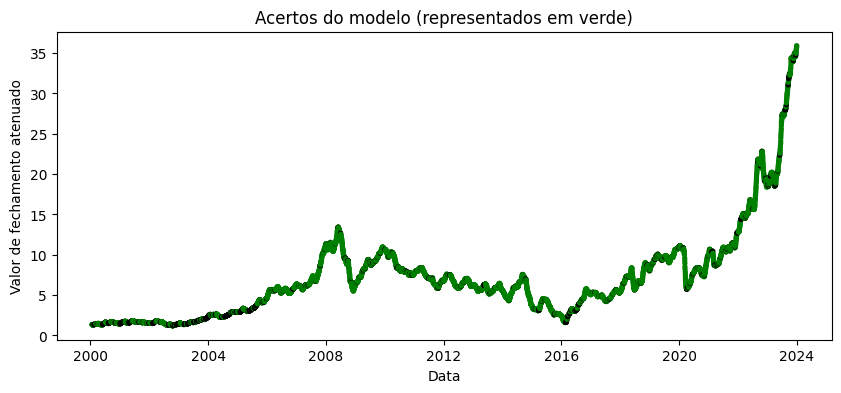

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

df_train["Date"] = pd.to_datetime(df_train["Date"], errors="coerce")
df_test["Date"]  = pd.to_datetime(df_test["Date"], errors="coerce")

plt.scatter(df_train["Date"], df_train["Smoothed_Close"],
            c=np.where(pred_train.flatten() == y_train, "green", "black"), s=8)
plt.scatter(df_test["Date"], df_test["Smoothed_Close"],
            c=np.where(pred_test.flatten() == y_test, "green", "black"), s=8)

plt.ylabel("Valor de fechamento atenuado")
plt.xlabel("Data")
plt.title("Acertos do modelo (representados em verde)")

#plt.grid(True, linestyle="--", alpha=0.1)
plt.show()

Uma particularidade desse modelo é que no início da série temporal, quando os dados são mais estáveis, o modelo tem mais dificuldade em predizer o comportamento (há uma quantidade maior de valores em preto). Porém ele performa bem quando há uma variação maior nos dados.

# Avaliação do Modelo - Matriz de Confusão

Confusion matrix:
 [[484  97]
 [101 521]]
Precision: 0.8430  |  Recall: 0.8376

Classification report:
               precision    recall  f1-score   support

           0     0.8274    0.8330    0.8302       581
           1     0.8430    0.8376    0.8403       622

    accuracy                         0.8354      1203
   macro avg     0.8352    0.8353    0.8353      1203
weighted avg     0.8355    0.8354    0.8354      1203



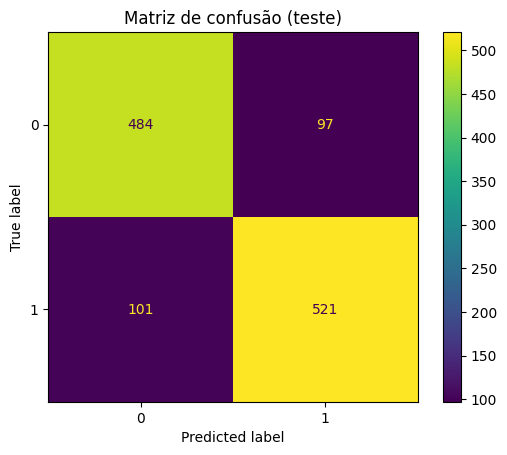

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report, ConfusionMatrixDisplay

#Métricas
cm = confusion_matrix(y_test, pred_test)
prec = precision_score(y_test, pred_test, zero_division=0)
rec  = recall_score(y_test, pred_test, zero_division=0)

print("Confusion matrix:\n", cm)
print(f"Precision: {prec:.4f}  |  Recall: {rec:.4f}")
print("\nClassification report:\n", classification_report(y_test, pred_test, digits=4))

# 4) (opcional) Plot da matriz de confusão
ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot(values_format="d")
plt.title("Matriz de confusão (teste)")
plt.show()

# Avaliação do Modelo - Retorno Financeiro

In [ ]:
df = pd.concat([df_train, df_test])

In [ ]:
y_predito = pd.concat([pd.Series(pred_train.flatten()), pd.Series(pred_test.flatten())])
print(y_predito.head())
print(y_predito.unique())
print(y_predito.value_counts())

0    0
1    0
2    0
3    0
4    0
dtype: int64
[0 1]
0    3972
1    2039
Name: count, dtype: int64


In [ ]:
df_modelo = pd.concat([df["Date"], df["Close"], y_predito], axis=1)

In [ ]:
df_modelo.columns = ['Date', 'Close', 'Label']
df_modelo.head()

,Date,Close,Label
0,2000-01-24,1.274788,0
1,2000-01-25,1.274788,0
2,2000-01-26,1.290096,0
3,2000-01-27,1.280960,0
4,2000-01-28,1.280960,0


Abaixo criamos uma função que considera um caixa inicial e um número inicial de ações, e que cada vez que o rótulo 1 aparece 1 ação é comprada, e quando o rótulo 0 aparece 1 ação é vendida. Essa função serve apenas o propósito de compararmos como o modelo ajustado usando Rede TCN (Temporal Convolutional Networks) performam em relação aos rótulos estabelecidos por especialistas.

In [ ]:
def retorno_financeiro(df, caixa_inicial, acoes_inicial):
  Ci = caixa_inicial
  Qi = acoes_inicial
  rotulos = df["Label"]
  precos = df["Close"]
  patrimonio = []
  patrimoio_inicial = Ci + (Qi * precos.iloc[0])
  for i in range(1, len(rotulos)):
    if rotulos.iloc[i] == 1:
      Ci = Ci - (precos.iloc[i-1])
      Qi = Qi + 1
    elif rotulos.iloc[i] == 0:
      Ci = Ci + (precos.iloc[i-1] )
      Qi = Qi - 1
    patrimonio.append(Ci + (Qi * precos.iloc[i]))

  patrimonio_final = patrimonio[-1]
  print(f"O patrimonio inicial: {patrimonio[0]:.2f}")
  print(f"O patrimônio final obtido foi de: {patrimonio_final:.2f}")
  return patrimonio

In [ ]:
retorno_especialista = retorno_financeiro(df, 10000, 10000)

O patrimonio inicial: 22747.88
O patrimônio final obtido foi de: 464407.65


In [ ]:
retorno_modelo = retorno_financeiro(df_modelo, 10000, 10000)

O patrimonio inicial: 22747.88
O patrimônio final obtido foi de: 314436.50


No caso desse modelo, que tem mais erros no início da série temporal, prevendo muitos rótulos de venda, vamos estabelecer um número inicial de ações maior que nos outros casos, a fim de não tornar o número de ações negativo na nossa função, o que alteraria o sinal de um dos membros da equação de patrimônio gerando um resultado errôneo.

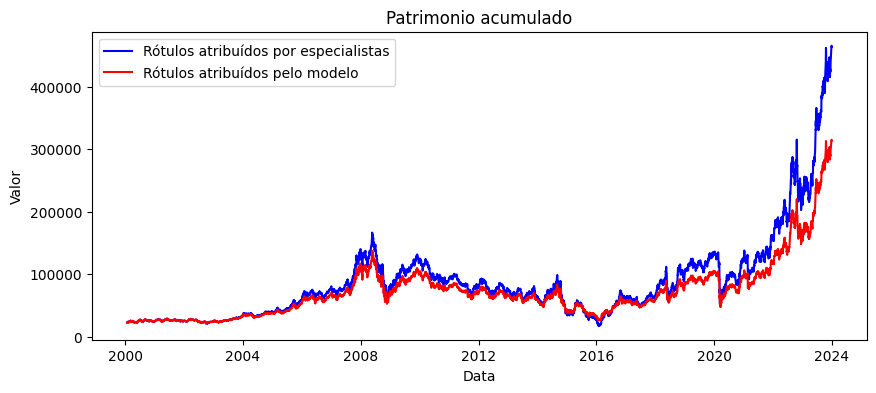

In [ ]:
plt.figure(figsize=(10,4))

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df_modelo["Date"]  = pd.to_datetime(df_modelo["Date"], errors="coerce")

plt.plot(df["Date"][1:], retorno_especialista, color="blue", label="Rótulos atribuídos por especialistas")
plt.plot(df_modelo["Date"][1:], retorno_modelo, color="red", label="Rótulos atribuídos pelo modelo")


plt.ylabel("Valor")
plt.xlabel("Data")
plt.title("Patrimonio acumulado")
plt.legend()

plt.show()

Aqui podemos ver que o nosso modelo, apresentado pela curva em vermelho apresenta um resultado financeiro similar ao que seria obtido por ações tomadas por especialistas. Ainda é possível alterar a arquitetura da rede para obter resultados ainda mais expressivos, mas o trabalho desenvolvido prova que redes temporais convolucionais são uma ferramenta poderosa para tratar de problemas de classificação em séries temporais.     

# Referências

BAI, Shaojie; KOLTER, J. Zico; KOLTUN, Vladlen. An empirical evaluation of generic convolutional and recurrent networks for sequence modeling. arXiv preprint arXiv:1803.01271, 2018. Disponível em: https://arxiv.org/abs/1803.01271. Acesso em: 3 set. 2025.

DAI, W.; AN, Y.; LONG, W. Price change prediction of ultra high frequency financial data based on temporal convolutional network. Procedia Computer Science, [S.l.], v. 199, p. 1177–1183, 2022. DOI: 10.1016/j.procs.2022.01.149. Disponível em: https://www.sciencedirect.com/science/article/pii/S1877050922001508. Acesso em: 3 set. 2025.

FAJOU, Justin; MCCARREN, Andrew. Forecasting gold prices using temporal convolutional networks. In: AICS 2021 – The 29th Irish Conference on Artificial Intelligence and Cognitive Science, 29., 2021, Dublin, Republic of Ireland. CEUR Workshop Proceedings, v. 3105, CEUR-WS.org, 2022. Disponível em: https://ceur-ws.org/Vol-3105/paper18.pdf. Acesso em: 3 set. 2025.